<a href="https://colab.research.google.com/github/paro2708/SER517_Group35_Capstone/blob/GazeRefineNet/EyeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To add

# EyeNet

EyeNet model to be used to tranfer learning to GazeRefineNet model

In [ ]:
import torchvision.models as models
import torch
from torch import nn
import numpy as np
import math
import pdb

In [ ]:
class EyeNet(nn.Module):
  def __init__(self, use_rnn=True):
    super(EyeNet, self).__init__()
    self.resnet = models.resnet18(
        #block = models.resnet.BasicBlock,
        #layers = [2,2,2,2],
        pretrained=False,        # Not using pre-trained weights
        num_classes=128,        # (IMP)Number of output classes - needs to be defined based on number of eye features needed
        norm_layer=nn.InstanceNorm2d,  # Normalization layer - layers need to be added
    )
    self.use_rnn = use_rnn

    # Optional recurrent component - GRUCell
    if use_rnn:
            self.rnn = nn.GRUCell(input_size=128, hidden_size=128)
            #self.fc_gaze = nn.Linear(128, 3)  # Output size for gaze direction

    self.fc_gaze = nn.Sequential(
                    nn.Linear(128, 128),
                    nn.SELU(inplace=True),
                    nn.Linear(128, 2, bias=False),
                    nn.Tanh(),
                )  # Output size for gaze direction
    self.fc_pupil = nn.Sequential(
                      nn.Linear(128, 128),
                      nn.SELU(inplace=True),
                      nn.Linear(128, 1),
                      nn.ReLU(inplace=True),
                  )  # Output size for pupil size

  def forward(self, input_eye_image, side, rnn_output=None):

    features = self.resnet(input_eye_image)

    if self.use_rnn:
      rnn_features=features
      batch_size, feature_size = features.shape
      hidden = torch.zeros(batch_size, 128, device=rnn_features.device)
      previous_results = []
      output=[]

      #pdb.set_trace()
      for i in range(batch_size):  # Loop through layers

        if rnn_output is not None:
            previous_results = output[i-1] if i>0 else None

        GRUResult= self.rnn(rnn_features,hidden)

        if isinstance(GRUResult, tuple):
          rnn_features=GRUResult[0]
          output[i] = GRUResult
        else:
          rnn_features = GRUResult
          output.append(GRUResult)

        # output.append(rnn_cell(rnn_features, previous_results))  # Forward pass through GRU cell
        # rnn_features=output
      features=rnn_features
      #pdb.set_trace()
      print("Features shape after GRUCell or ResNet:", features.shape)

    gaze_direction = (0.5 * np.pi) * self.fc_gaze(features)
    pupil_size =self.fc_pupil(features)
    print("Gaze Direction shape before linear layer:", gaze_direction.shape)
    print("Pupil Size shape before linear layer:", pupil_size.shape)
    return gaze_direction, pupil_size

   # Define custom loss functions
  def gaze_loss(g, g_hat):
    loss = torch.mean(torch.acos(torch.sum(g * g_hat, dim=1) / (torch.norm(g, dim=1) * torch.norm(g_hat, dim=1))) * (180 / torch.pi))
    return loss

  def pupil_loss(p, p_hat):
    loss = torch.mean(torch.abs(p - p_hat))
    return loss

#To test if the models can run image data for eye coordinates
#eyenet = EyeNet(use_rnn=True)  # You can set use_rnn to True or False based on your requirement

# Generate sample input data (e.g., random tensor with appropriate dimensions)
# assuming batch size = 1, 3 channels (RGB), and image size 224x224
# input_data = torch.randn(1, 3, 224, 224)

# # Pass the input data through the EyeNet model to get predictions
# gaze_direction, pupil_size = eyenet(input_data)

# magnitude = torch.norm(gaze_direction, p=2)

# # Print the predictions
# print("Predicted Gaze Direction:", gaze_direction)
# print("Predicted Pupil Size:", pupil_size)
# print("Normalized Gaze Direction Magnitude(in radians):", magnitude.item())




In [ ]:
from torchvision import transforms
from PIL import Image

eyenet= EyeNet()

# Load and preprocess the image
image_path = '/content/sample_data/00000.jpg'
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open(image_path)
img_tensor = preprocess(img)  # Add batch dimension

print(img_tensor.unsqueeze(0).shape)

#%debug
# Assuming the EyeNet model is already defined and initialized as eyenet
gaze_direction, pupil_size = eyenet(img_tensor.unsqueeze(0))

print("Predicted Gaze Direction:", gaze_direction)
print("Predicted Pupil Size:", pupil_size)
magnitude = torch.norm(gaze_direction, p=2)
magnitude = magnitude *(180/np.pi)
print("Normalized Gaze Direction Magnitude(in radians):", magnitude.item())


torch.Size([1, 3, 224, 224])
Features shape after GRUCell or ResNet: torch.Size([1, 128])
Gaze Direction shape before linear layer: torch.Size([1, 2])
Pupil Size shape before linear layer: torch.Size([1, 1])
Predicted Gaze Direction: tensor([[0.0680, 0.0926]], grad_fn=<TanhBackward0>)
Predicted Pupil Size: tensor([[0.0178]], grad_fn=<ReluBackward0>)
Normalized Gaze Direction Magnitude(in radians): 6.5809712409973145


# Common functions and calculations between EyeNet and GazeRefineNet

To intersect the gaze origin and gaze direction with screen plane with z = 0

In [ ]:
def calculate_intersection(origin, direction):
    global plane_normal, plane_point
    if plane_normal is None:
        plane_normal = torch.tensor([0, 0, 1], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)
        plane_point = torch.tensor([1, 0, 0], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

    normal_vector = plane_normal
    point_on_plane = plane_point
    direction = direction.view(-1, 3, 1)
    origin = origin.view(-1, 3, 1)

    numerator = torch.bmm((point_on_plane - origin).transpose(1, 2), normal_vector).squeeze(2)
    denominator = torch.bmm(direction.transpose(1, 2), normal_vector).squeeze(2) + 1e-7
    t = (numerator / denominator).unsqueeze(2)

    intersection_point = origin + t * direction
    intersection_point_2d = intersection_point[:, :2, 0]  # Keep only x and y coordinates

    return intersection_point_2d.view(-1, 2)  # Reshape to ensure it's always a 2


    # Sample gaze origin point (x, y, z)
origin = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float32).view(1, 3, 1)

# Sample gaze direction vector (dx, dy, dz)
direction = torch.tensor([0.0, 0.0, -1.0], dtype=torch.float32).view(1, 3, 1)

# Assuming the 'device' variable is defined, e.g.,
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize global variables if not already done
plane_normal = None
plane_point = None

# Call the function
intersection = calculate_intersection(origin, direction)

# Output the result
print("Intersection point:", intersection)



Intersection point: tensor([[0.5000, 0.5000]])


# Common Models

In [ ]:
import torch
from torch import nn

class ConvRNNCell(nn.Module):
    """A convolutional RNN cell that integrates spatial information."""

    def __init__(self, input_channels, output_channels):
        """Initializes the convolutional RNN cell.

        Args:
            input_channels (int): Number of channels in the input.
            output_channels (int): Number of channels in the output hidden state.
        """
        super(ConvRNNCell, self).__init__()
        self.output_channels = output_channels

        # Define convolution layer to process concatenated input and hidden state
        self.conv = nn.Conv2d(in_channels=input_channels + output_channels,
                              out_channels=output_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, prev_state=None):
        """Computes the cell's forward pass.

        Args:
            input_tensor (torch.Tensor): Input tensor.
            prev_state (torch.Tensor, optional): Previous hidden state.

        Returns:
            torch.Tensor: Updated hidden state.
        """
        if prev_state is None:
            # Initialize previous state if not provided
            prev_state = torch.zeros([input_tensor.size(0), self.output_channels] +
                                     list(input_tensor.shape[2:])).to(input_tensor.device)

        combined = torch.cat([input_tensor, prev_state], dim=1)  # Concatenate along the channel dimension
        hidden_state = torch.tanh(self.conv(combined))
        return hidden_state


In [ ]:
class CLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.gates = nn.Conv2d(self.input_size + self.hidden_size, 4 * self.hidden_size,
                               kernel_size=3, padding=1)

# HeatMap

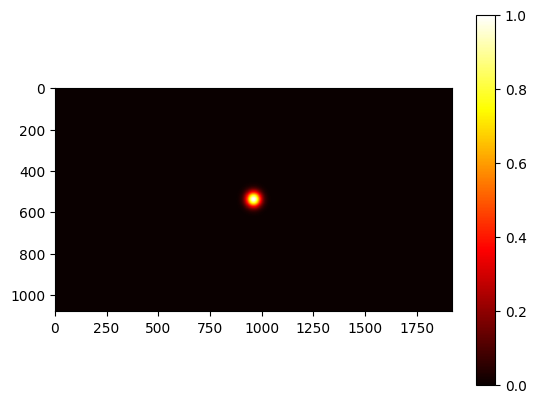

In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def generate_heatmap(image_size, pos, sigma=25):
    """
    Generate a Gaussian heatmap centered at pos (x, y).

    :param image_size: Tuple (width, height) of the output image.
    :param pos: Tuple (x, y) position of the gaze point on the screen.
    :param sigma: Standard deviation of the Gaussian distribution.
    :return: Generated heatmap as a 2D numpy array.
    """
    # Create an empty image
    heatmap = np.zeros((image_size[1], image_size[0]), dtype=np.float32)

    # Ensure the position is integer
    pos = [int(p) for p in pos]

    # Set the pixel at the gaze point to 1
    heatmap[pos[1], pos[0]] = 1

    # Apply Gaussian filter to create the heatmap
    heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma, mode='constant')

    # Normalize heatmap
    heatmap /= np.max(heatmap)

    return heatmap

# Example usage
image_size = (1920, 1080)  # Screen resolution
pos = (960, 540)  # Example PoG position
sigma = 25  # Standard deviation

heatmap1 = generate_heatmap(image_size, pos, sigma)



plt.imshow(heatmap1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


# Heatmap 2

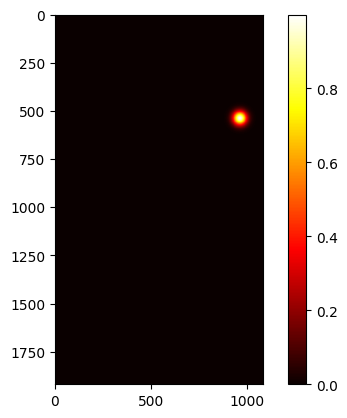

In [ ]:
import logging

import numpy as np

#from core import DefaultConfig
import matplotlib.pyplot as plt

# config = DefaultConfig()
# logger = logging.getLogger(__name__)


def gaussian_2d(shape, centre, sigma=1.0):
    """Generate heatmap with single 2D gaussian."""
    xs = np.arange(0.5, shape[1] + 0.5, step=1.0, dtype=np.float32)
    ys = np.expand_dims(np.arange(0.5, shape[0] + 0.5, step=1.0, dtype=np.float32), -1)
    alpha = -0.5 / (sigma**2)
    heatmap = np.exp(alpha * ((xs - centre[0])**2 + (ys - centre[1])**2))
    return heatmap


def onehot_from_values(v, v_min, v_max, n_bins, clipped=False):
    if clipped:
        v = np.clip(v, a_min=v_min+1e-6, a_max=v_max-1e-6)
    v = ((v - (v_min+1e-6)) / (v_max - v_min))  # values in [0, 1]
    hmap = gaussian_2d([n_bins, n_bins], v * n_bins, sigma=25)
    hmap = hmap.flatten()
    hmap *= 1.0 / np.sum(hmap)
    return hmap

shape = (1920, 1080)  # Size of the heatmap
centre = (960, 540)  # Center of the Gaussian blob
sigma = 25  # Spread of the Gaussian blob

# Generate heatmap
heatmap2 = gaussian_2d(shape, centre, sigma)

# Display the heatmap
plt.imshow(heatmap2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

Difference between the two heatmaps generated

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Assume heatmap1 and heatmap2 are your two heatmaps to compare
# They must be the same size

# Correlation Coefficient
def calculate_correlation(heatmap1, heatmap2):
    corr, _ = pearsonr(heatmap1.flatten(), heatmap2.flatten())
    return corr

# Mean Squared Error
def calculate_mse(heatmap1, heatmap2):
    return mean_squared_error(heatmap1.flatten(), heatmap2.flatten())

# Structural Similarity Index
def calculate_ssim(heatmap1, heatmap2):
    heatmap1 = heatmap1.astype(np.float32)
    heatmap2 = heatmap2.astype(np.float32)
    if heatmap1.shape != heatmap2.shape:
      heatmap2 = heatmap2.T
    return ssim(heatmap1, heatmap2)

# Example usage
# heatmap1 = np.random.rand(1920, 1080)
# heatmap2 = np.random.rand(1920, 1080)

print("Correlation Coefficient:", calculate_correlation(heatmap1, heatmap2))
print("Heatmap 1 shape", heatmap1.shape)
print("Heatmap 2 shape", heatmap2.shape)
print("MSE:", calculate_mse(heatmap1, heatmap2))
print("SSIM:", calculate_ssim(heatmap1, heatmap2))

Correlation Coefficient: -0.0038015607662193938
Heatmap 1 shape (1080, 1920)
Heatmap 2 shape (1920, 1080)
MSE: 0.0018938034
SSIM: 0.9849404238674698
